# Gradient Boosting models - NYC collisions dataset

import statements and function definition:

In [14]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, subplots, savefig, show
from sklearn.ensemble import GradientBoostingClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, horizontal_bar_chart, HEIGHT

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

file_tag = 'NYC_collisions'
target = 'PERSON_INJURY'

In [15]:
def plot_overfitting_study(xvalues, prd_trn, prd_tst, name, xlabel, ylabel):
    evals = {'Train': prd_trn, 'Test': prd_tst}
    plt.figure()
    multiple_line_chart(xvalues, evals, ax = None, title=f'Overfitting {name}', xlabel=xlabel, ylabel=ylabel, percentage=True)
    plt.savefig('images/overfitting_{name}.png')

## Dummified data with scaling

load dataframes:

In [16]:
train: DataFrame = read_csv('data/train_sets/with_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/with_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

train models:

<Figure size 600x450 with 0 Axes>

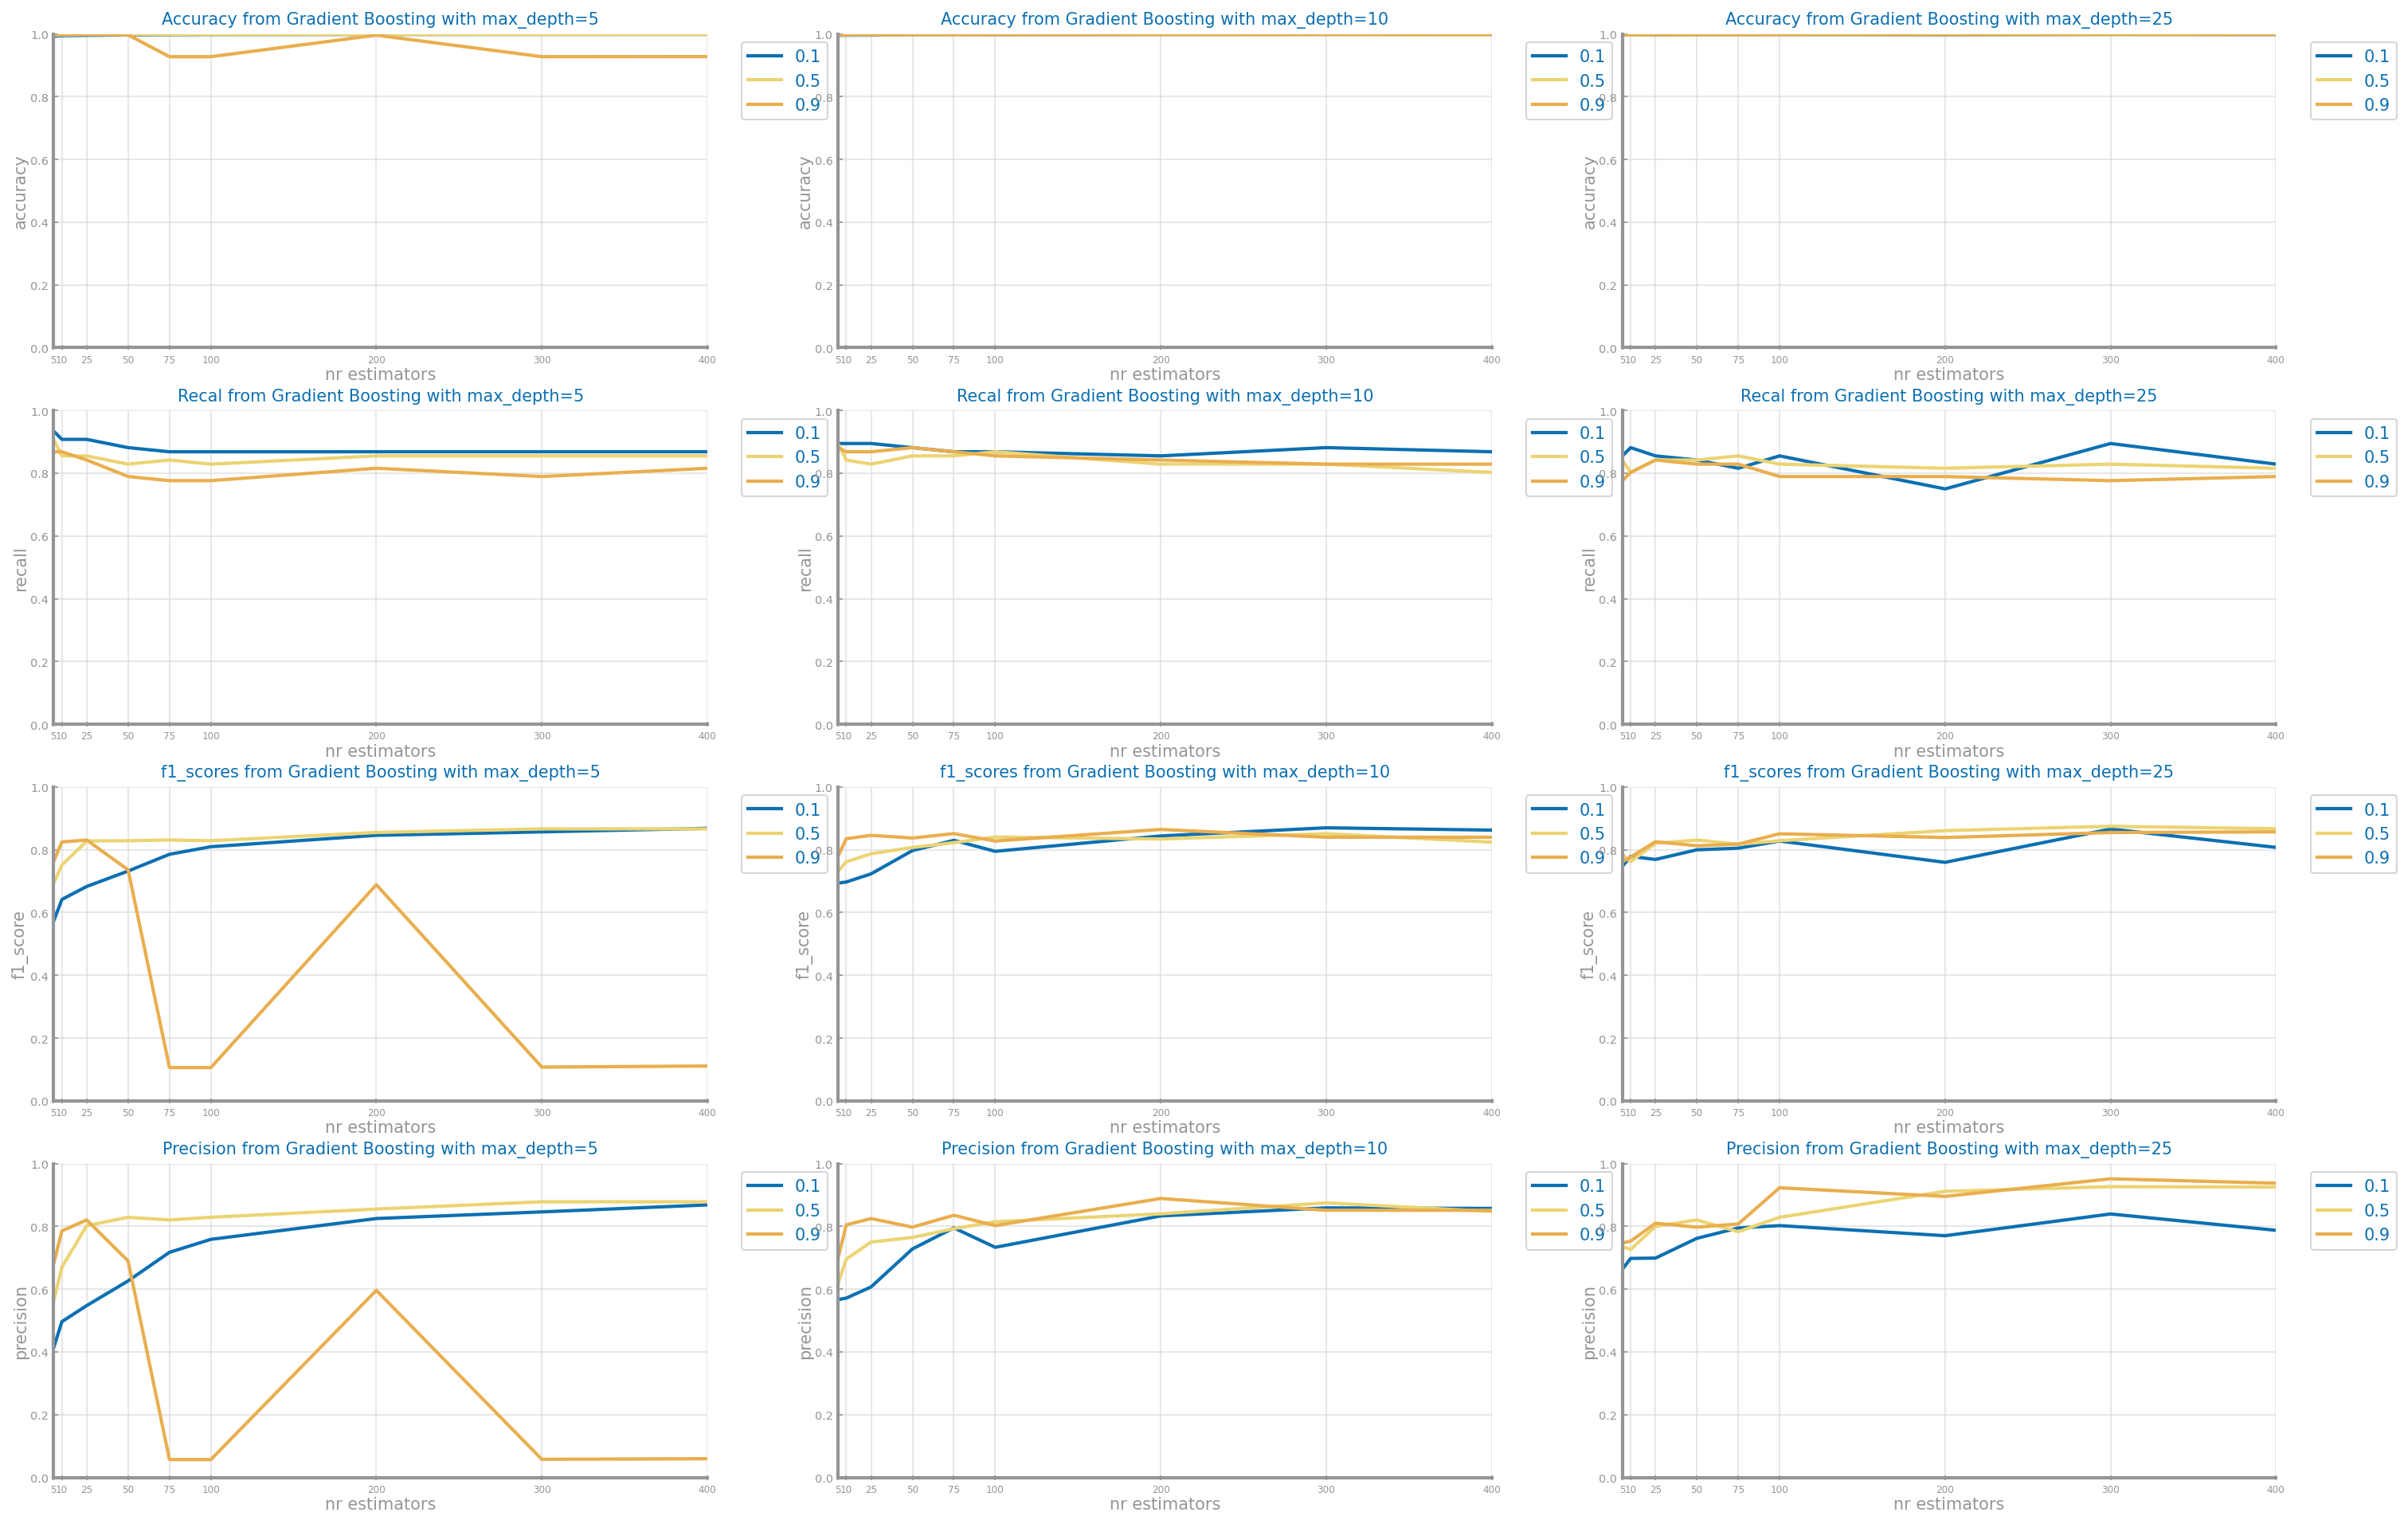

Best results with depth=25, learning rate=0.50 and 300 estimators, with accuracy=1.00


In [17]:
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
figure()
fig, axs = subplots(4, cols, figsize=(cols*2*HEIGHT, 4*HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    
    acc_values = {}
    recall_values = {}
    f1_values = {}
    precision_values = {}

    for lr in learning_rate:
        recall = []
        f1_score = []
        accuracy = []
        precision = []

        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            
            accuracy.append(metrics.accuracy_score(tstY, prdY))
            recall.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            f1_score.append(metrics.f1_score(tstY, prdY, pos_label="Killed"))
            precision.append(metrics.precision_score(tstY, prdY, pos_label="Killed"))

            if accuracy[-1] > last_best:
                best = (d, lr, n)
                last_best = accuracy[-1]
                best_model = gb
        
        precision_values[lr] = precision
        acc_values[lr] = accuracy
        recall_values[lr] = recall
        f1_values[lr] = f1_score

    multiple_line_chart(n_estimators, acc_values, ax=axs[0, k], title=f'Accuracy from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    multiple_line_chart(n_estimators, recall_values, ax=axs[1, k], title=f'Recal from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='recall', percentage=True)
    multiple_line_chart(n_estimators, f1_values, ax=axs[2, k], title=f'f1_scores from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='f1_score', percentage=True)
    multiple_line_chart(n_estimators, precision_values, ax=axs[3, k], title=f'Precision from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='precision', percentage=True)
savefig(f'images/{file_tag}_scl_gb_study.png')
show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

best model study:

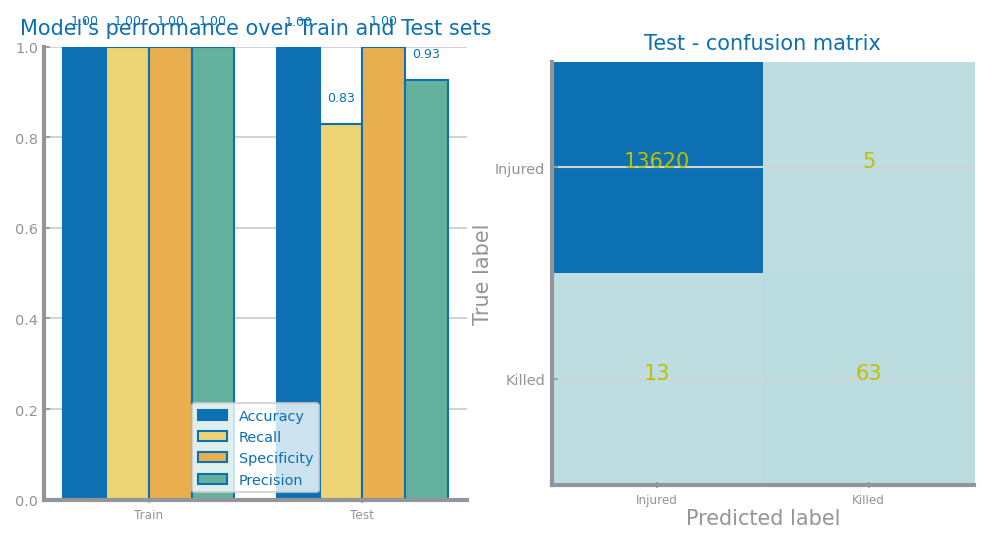

In [18]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_scl_gb_best.png')
show()

feature importance:

1. feature EMOTIONAL_STATUS_Conscious (0.8538598978916696)
2. feature EMOTIONAL_STATUS_Unknown (0.048690087964946324)
3. feature EMOTIONAL_STATUS_Shock (0.04818006950390268)
4. feature EMOTIONAL_STATUS_Semiconscious (0.012704254810512095)
5. feature BODILY_INJURY_Neck (0.008201755463429654)
6. feature EMOTIONAL_STATUS_Incoherent (0.007839806458938066)
7. feature EMOTIONAL_STATUS_Does Not Apply (0.0044020414183200945)
8. feature PED_ACTION_Crossing Against Signal (0.0043773816807183156)
9. feature COMPLAINT_Complaint of Pain or Nausea (0.0019415779452429485)
10. feature PERSON_AGE (0.0012217398933230966)
11. feature COMPLAINT_Fracture - Distorted - Dislocation (0.0009490943840175095)
12. feature EJECTION_Ejected (0.0007784442916817634)
13. feature CRASH_DATE (0.0007370193315073616)
14. feature EMOTIONAL_STATUS_Apparent Death (0.0007305978494420617)
15. feature COMPLAINT_Concussion (0.0005669975985713569)
16. feature COMPLAINT_Minor Bleeding (0.0005206593059618144)
17. feature COMPLAINT_

<Figure size 600x450 with 0 Axes>

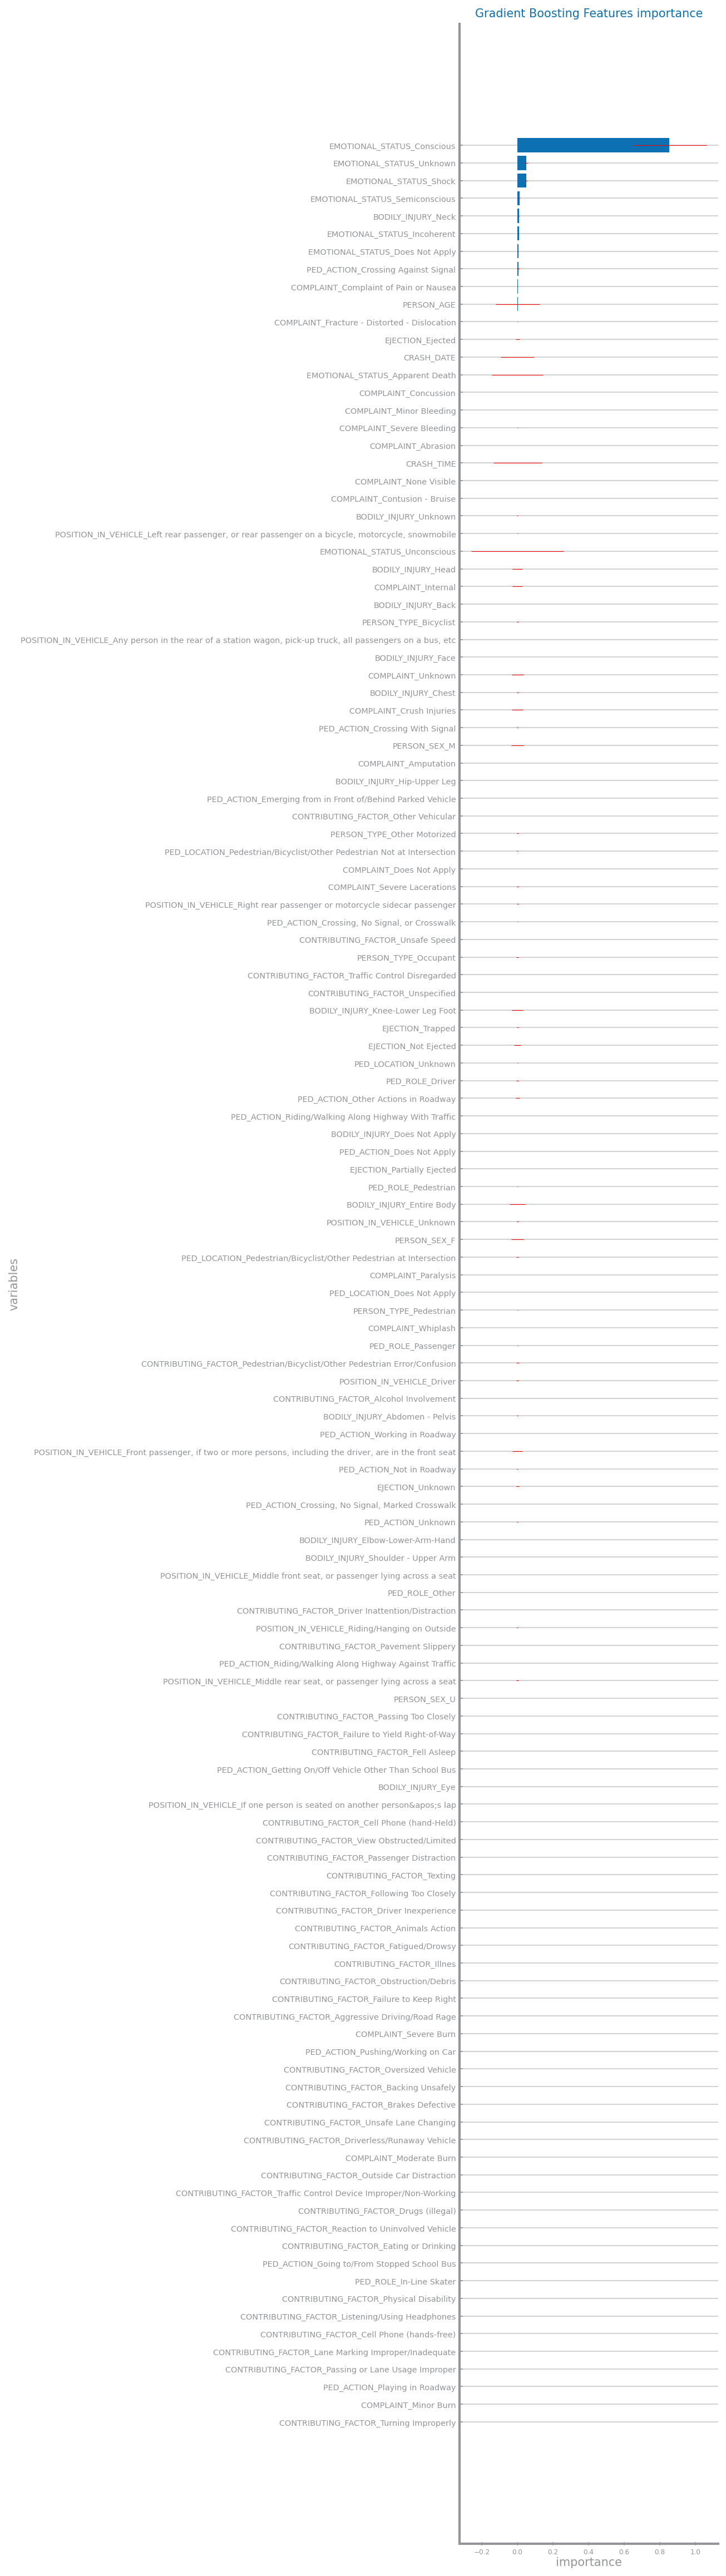

In [19]:
from numpy import std, argsort

variables = train.columns
importances = best_model.feature_importances_
indices = argsort(importances)[::-1]
stdevs = std([tree[0].feature_importances_ for tree in best_model.estimators_], axis=0)
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
fig, axs = subplots(1, 1, figsize=(HEIGHT, 10*HEIGHT), squeeze=False)
horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_scl_gb_ranking.png')

overfitting study:

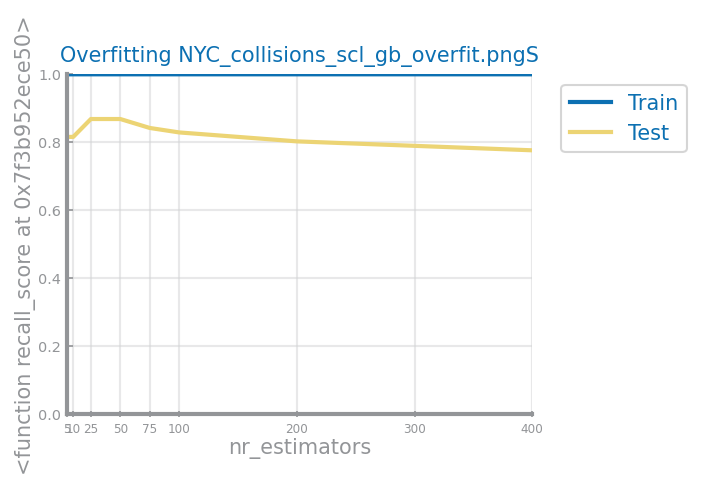

In [20]:
lr = 0.7
max_depth = 10
eval_metric = metrics.recall_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
    gb.fit(trnX, trnY)
    prd_tst_Y = gb.predict(tstX)
    prd_trn_Y = gb.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y, pos_label='Killed'))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y, pos_label='Killed'))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name='NYC_collisions_scl_gb_overfit.pngS', xlabel='nr_estimators', ylabel=str(eval_metric))

## Dummified data without scaling:

load dataframes:

In [21]:
train: DataFrame = read_csv('data/train_sets/no_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/no_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

train models:

<Figure size 600x450 with 0 Axes>

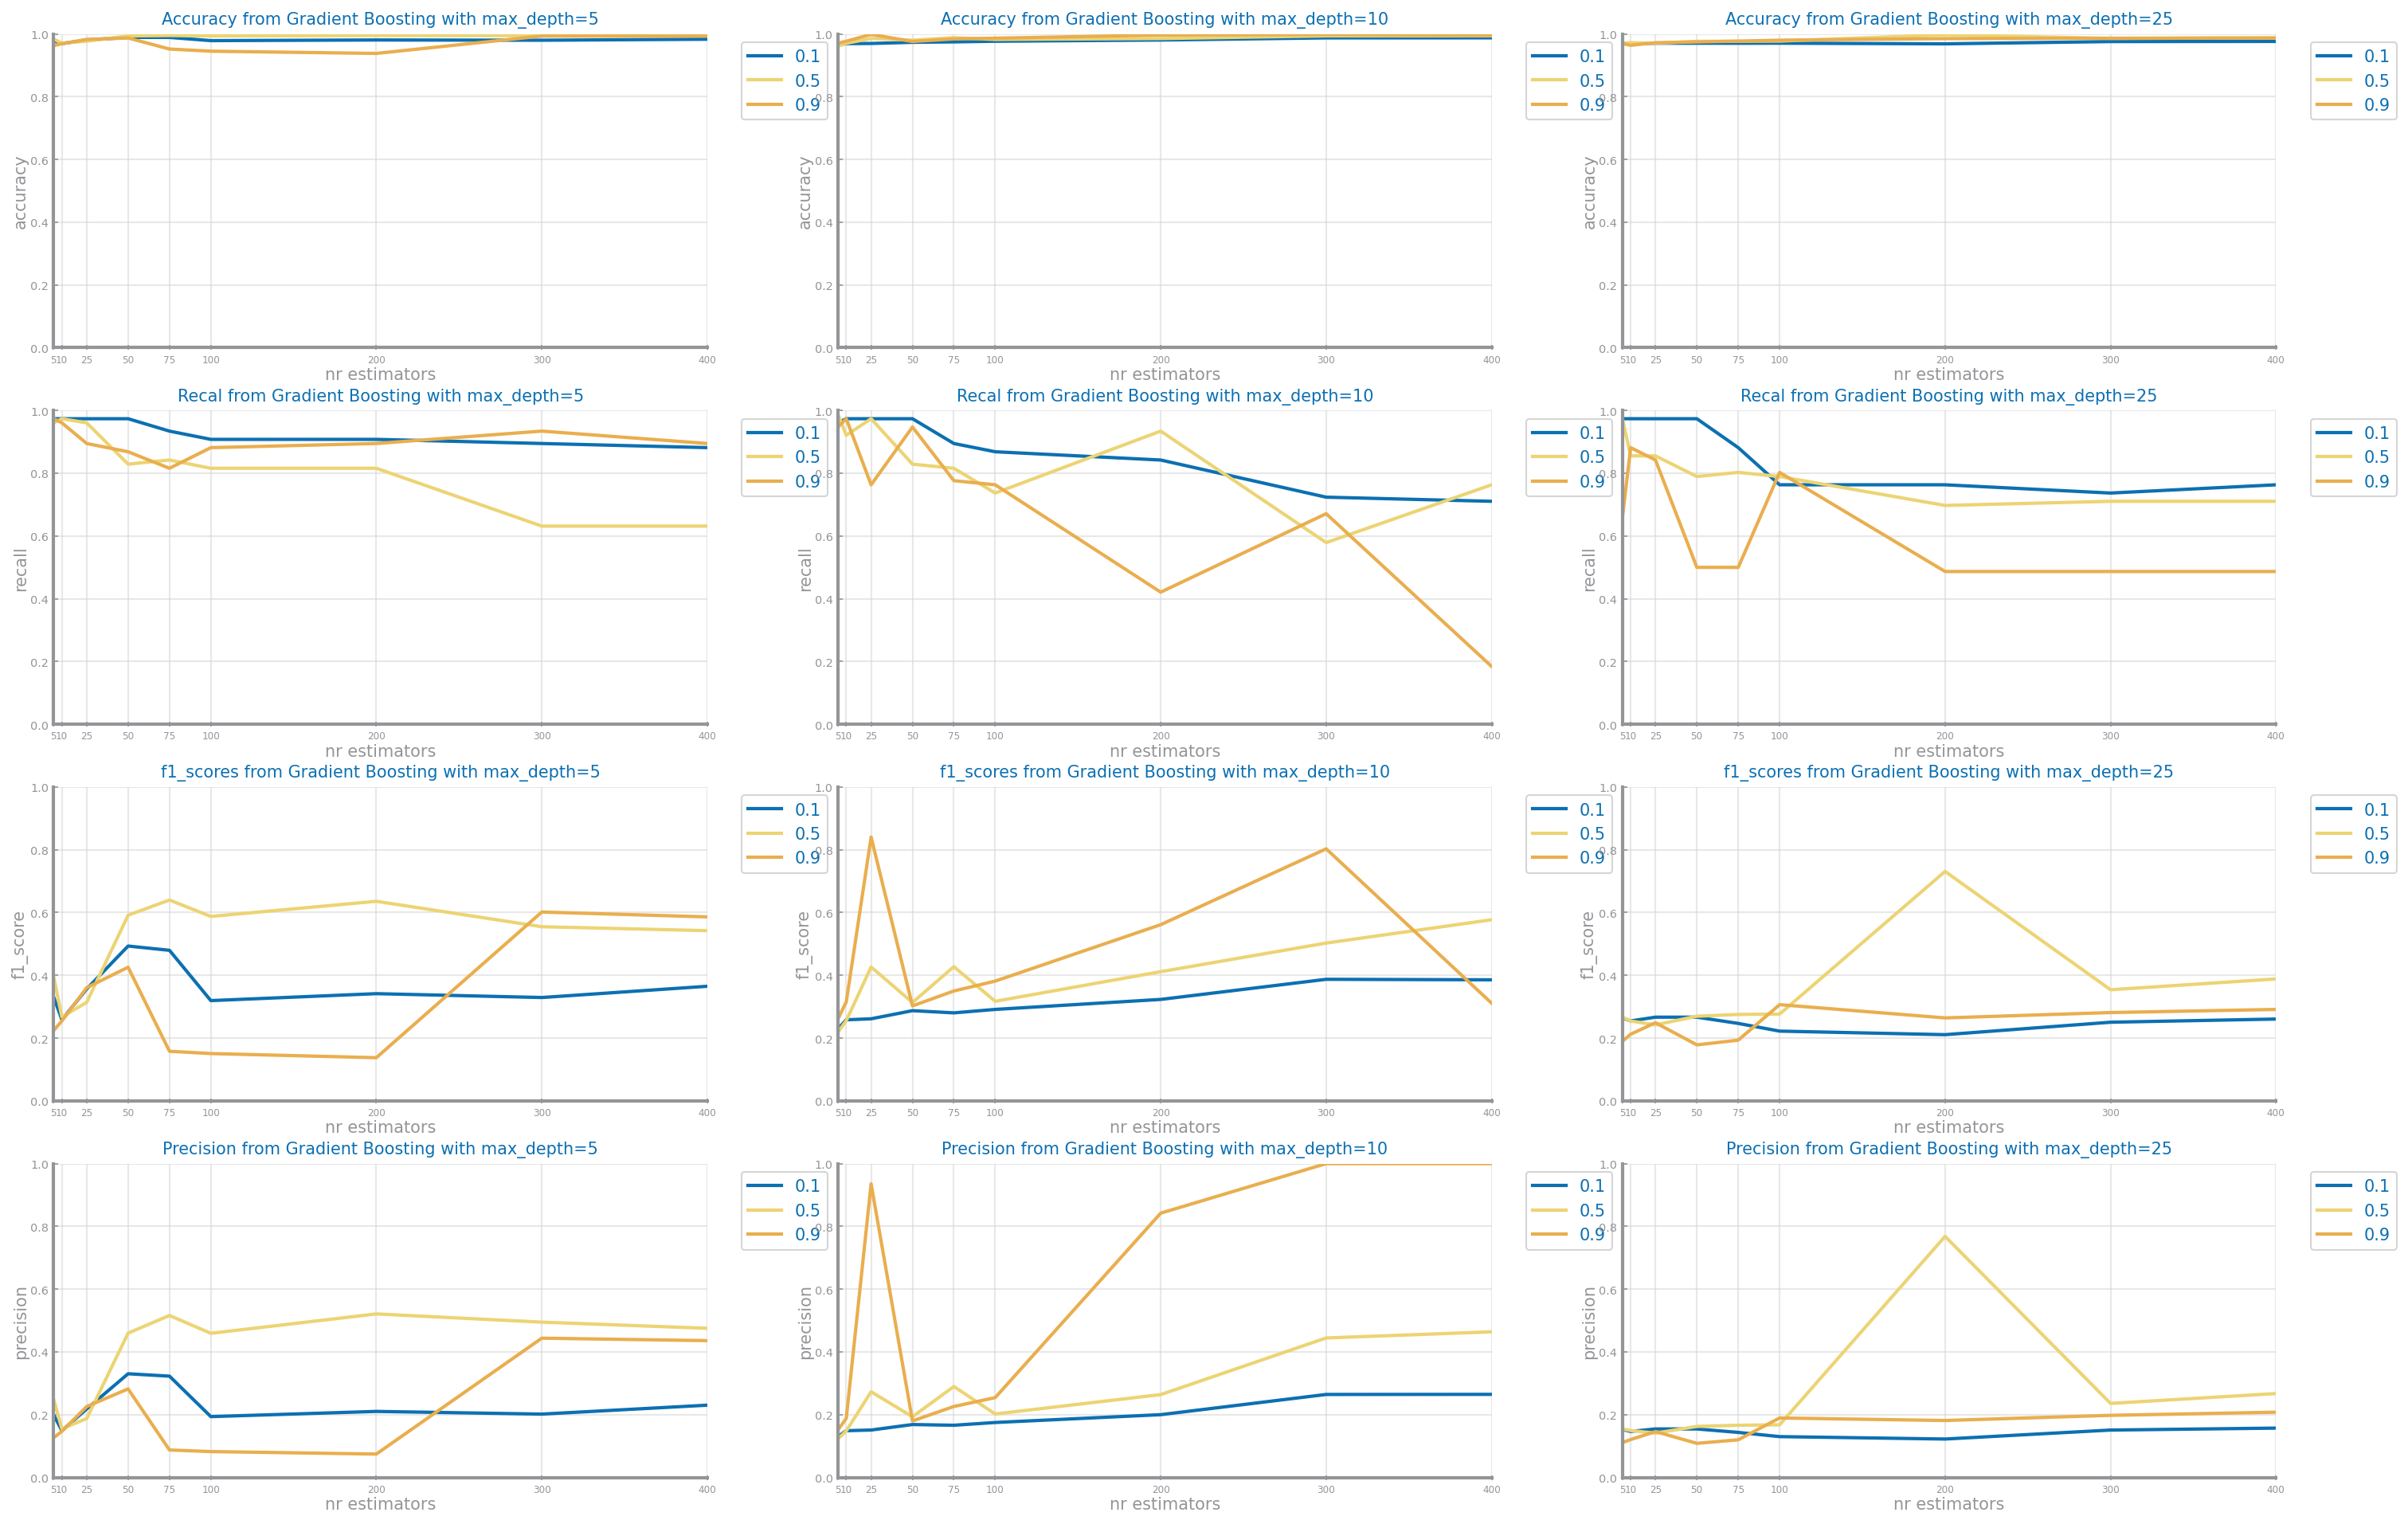

Best results with depth=10, learning rate=0.90 and 25 estimators, with accuracy=1.00


In [22]:
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
figure()
fig, axs = subplots(4, cols, figsize=(cols*2*HEIGHT, 4*HEIGHT), squeeze=False)

for k in range(len(max_depths)):
    d = max_depths[k]
    acc_values = {}
    recall_values = {}
    f1_values = {}
    precision_values = {}
    for lr in learning_rate:
        recall = []
        f1_score = []
        accuracy = []
        precision = []

        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            
            accuracy.append(metrics.accuracy_score(tstY, prdY))
            recall.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            f1_score.append(metrics.f1_score(tstY, prdY, pos_label="Killed"))
            precision.append(metrics.precision_score(tstY, prdY, pos_label="Killed"))

            if accuracy[-1] > last_best:
                best = (d, lr, n)
                last_best = accuracy[-1]
                best_model = gb
        
        precision_values[lr] = precision
        acc_values[lr] = accuracy
        recall_values[lr] = recall
        f1_values[lr] = f1_score

    multiple_line_chart(n_estimators, acc_values, ax=axs[0, k], title=f'Accuracy from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    multiple_line_chart(n_estimators, recall_values, ax=axs[1, k], title=f'Recal from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='recall', percentage=True)
    multiple_line_chart(n_estimators, f1_values, ax=axs[2, k], title=f'f1_scores from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='f1_score', percentage=True)
    multiple_line_chart(n_estimators, precision_values, ax=axs[3, k], title=f'Precision from Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='precision', percentage=True)
savefig(f'images/{file_tag}_gb_study.png')
show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

best model study:

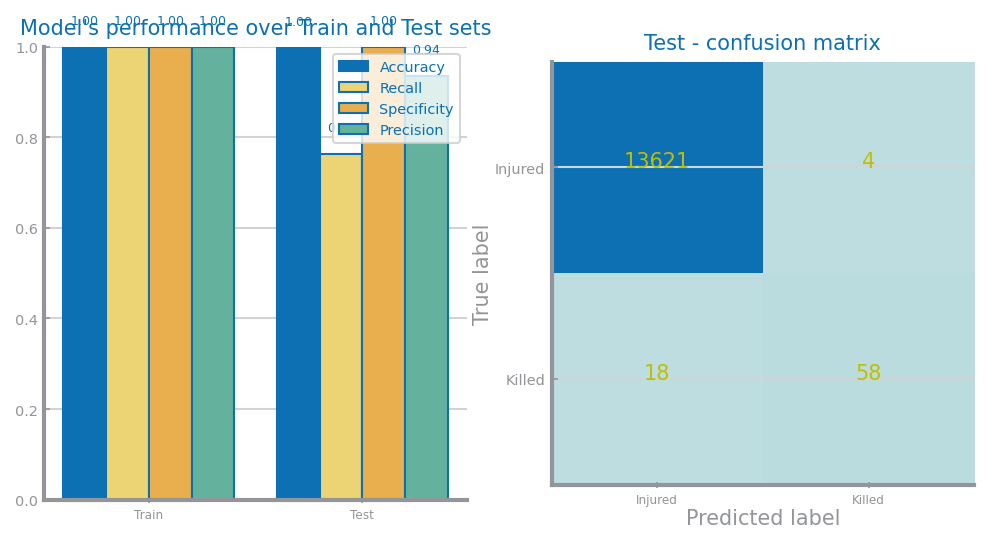

In [23]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_gb_best.png')
show()

feature importance:

1. feature EMOTIONAL_STATUS_Conscious (0.8532673668656778)
2. feature EMOTIONAL_STATUS_Unknown (0.04856572201518666)
3. feature EMOTIONAL_STATUS_Shock (0.04805685414589541)
4. feature EMOTIONAL_STATUS_Semiconscious (0.012673888566364654)
5. feature BODILY_INJURY_Neck (0.00809111174177658)
6. feature EMOTIONAL_STATUS_Incoherent (0.007815114797286726)
7. feature PED_ACTION_Crossing Against Signal (0.004455503457946283)
8. feature EMOTIONAL_STATUS_Does Not Apply (0.004406300568538814)
9. feature COMPLAINT_Complaint of Pain or Nausea (0.0019296772120934729)
10. feature EMOTIONAL_STATUS_Unconscious (0.0013710635812683738)
11. feature CRASH_DATE (0.0011459860625875143)
12. feature COMPLAINT_Fracture - Distorted - Dislocation (0.0009747031138328981)
13. feature PERSON_AGE (0.0009285404682718837)
14. feature EJECTION_Ejected (0.000806823062191672)
15. feature COMPLAINT_Concussion (0.0005927540155859664)
16. feature COMPLAINT_Minor Bleeding (0.0005453389343627257)
17. feature CRASH_TIME (0.0005

<Figure size 600x450 with 0 Axes>

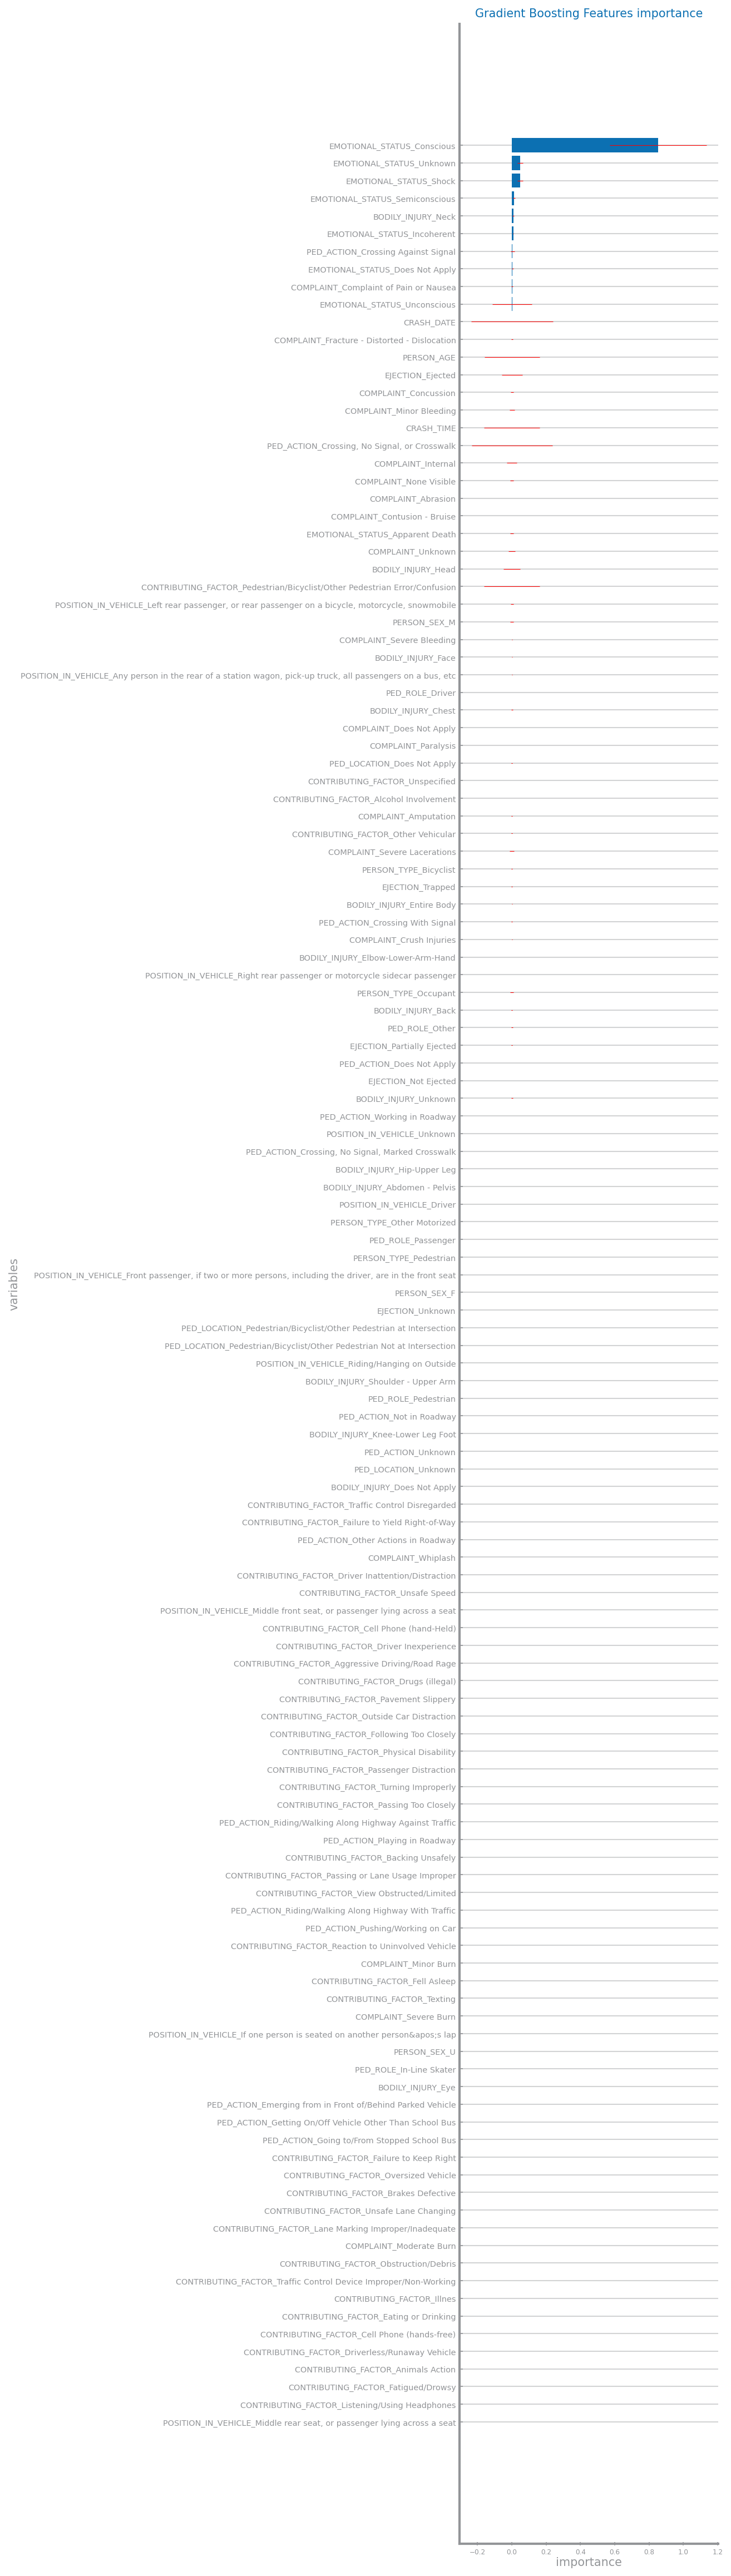

In [24]:
from numpy import std, argsort

variables = train.columns
importances = best_model.feature_importances_
indices = argsort(importances)[::-1]
stdevs = std([tree[0].feature_importances_ for tree in best_model.estimators_], axis=0)
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
fig, axs = subplots(1, 1, figsize=(HEIGHT, 10*HEIGHT), squeeze=False)
horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_gb_ranking.png')

overfitting study:

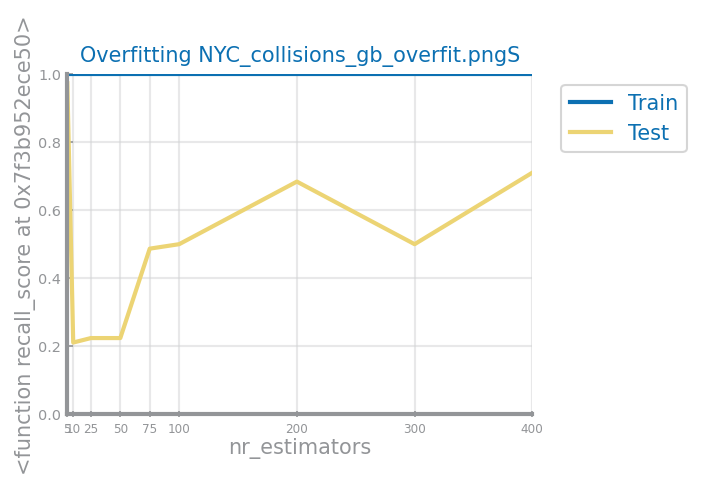

In [25]:
lr = 0.7
max_depth = 10
eval_metric = metrics.recall_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
    gb.fit(trnX, trnY)
    prd_tst_Y = gb.predict(tstX)
    prd_trn_Y = gb.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y, pos_label='Killed'))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y, pos_label='Killed'))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name='NYC_collisions_gb_overfit.pngS', xlabel='nr_estimators', ylabel=str(eval_metric))